# TP:Context-Aware Recommender System     

*   Prepared by   : Chaimaa BOUABD
*   Supervised by : Pr. Sara QASSIMI


       
       



# Context-Aware book recommender system

### Import libraries

In [14]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, concatenate, Dense
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

### 1- Data Loading and Preprocessing

In [15]:
# Load datasets (Books, Ratings, Users)
books = pd.read_csv('./Books.csv')
ratings = pd.read_csv('./Ratings.csv')
users = pd.read_csv('./Users.csv')


In [16]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [17]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [18]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [19]:
# Merge datasets to get additional user and book information
merged_data = pd.merge(pd.merge(ratings, books, on='ISBN'), users, on='User-ID')

# Fill missing values in 'Book-Author' with a placeholder.

missing_authors=merged_data['Book-Author'].fillna('Unknown_Author', inplace=True)

# Encode user, book, location, and author IDs using categorical codes
encoder = LabelEncoder()
merged_data['User-ID'] = encoder.fit_transform(merged_data['User-ID'])
merged_data['ISBN'] = encoder.fit_transform(merged_data['ISBN'])
merged_data['Location'] = encoder.fit_transform(merged_data['Location'])
merged_data['Book-Author'] = encoder.fit_transform(merged_data['Book-Author'])


### 2 - Data Splitting

In [20]:
# Shuffle the merged dataset
merged_data = merged_data.sample(frac=1).reset_index(drop=True)

# Define cutoff point for splitting (e.g., 80% train, 20% test)
train_size = 0.8
train_index = int(train_size * len(merged_data))

# Split the dataset into training and testing sets
train_data = merged_data[:train_index]
test_data = merged_data[train_index:]


In [21]:
train_data.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Location,Age
0,28066,73340,6,Frog,34255,1992,British American Publishing,http://images.amazon.com/images/P/0945167415.0...,http://images.amazon.com/images/P/0945167415.0...,http://images.amazon.com/images/P/0945167415.0...,12655,44.0
1,8901,25846,0,The King of Torts,18382,2003,Doubleday Books,http://images.amazon.com/images/P/0385508042.0...,http://images.amazon.com/images/P/0385508042.0...,http://images.amazon.com/images/P/0385508042.0...,15214,57.0
2,38131,84757,10,Das Jesus Video.,1478,2000,LÃ?Â¼bbe,http://images.amazon.com/images/P/3404142942.0...,http://images.amazon.com/images/P/3404142942.0...,http://images.amazon.com/images/P/3404142942.0...,4775,35.0
3,57671,7760,0,The Shape of Water,1445,2002,Penguin Books,http://images.amazon.com/images/P/0142002399.0...,http://images.amazon.com/images/P/0142002399.0...,http://images.amazon.com/images/P/0142002399.0...,5567,NaN
4,58525,48774,10,Silent Night : A Christmas Suspense Story,25062,1996,Pocket,http://images.amazon.com/images/P/067100042X.0...,http://images.amazon.com/images/P/067100042X.0...,http://images.amazon.com/images/P/067100042X.0...,5297,NaN


In [22]:
test_data.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Location,Age
583764,68336,84748,8,Von Zeit zu Zeit. Die Vergangenheit ist nur ei...,15602,1998,LÃ?Â¼bbe,http://images.amazon.com/images/P/3404139968.0...,http://images.amazon.com/images/P/3404139968.0...,http://images.amazon.com/images/P/3404139968.0...,12980,NaN
583765,50638,22487,6,Awakening,20213,1982,Avon,http://images.amazon.com/images/P/0380002450.0...,http://images.amazon.com/images/P/0380002450.0...,http://images.amazon.com/images/P/0380002450.0...,6126,34.0
583766,64845,42280,0,Death on the Nile,424,1978,Bantam Books,http://images.amazon.com/images/P/0553125397.0...,http://images.amazon.com/images/P/0553125397.0...,http://images.amazon.com/images/P/0553125397.0...,3518,39.0
583767,12582,80007,10,Chobits (Chobits),6460,2003,TokyoPop,http://images.amazon.com/images/P/1591822580.0...,http://images.amazon.com/images/P/1591822580.0...,http://images.amazon.com/images/P/1591822580.0...,7383,30.0
583768,67779,28139,0,Point of Origin,28404,1998,Putnam Pub Group,http://images.amazon.com/images/P/0399143947.0...,http://images.amazon.com/images/P/0399143947.0...,http://images.amazon.com/images/P/0399143947.0...,3717,NaN


### 3 - Building the Context-Aware Recommender Model:

In [23]:

# Define constants
K = 50  # Latent dimensionality
mu = train_data['Book-Rating'].mean()#Calculate the mean of the training set ratings (mu).
epochs = 10#Set the number of epochs (epochs)
reg = 0.001#regularization penalty (reg)

# Determine unique counts of users (N), books (M), locations (L), and authors (A)
N = len(merged_data['User-ID'].unique())
M = len(merged_data['ISBN'].unique())
L = len(merged_data['Location'].unique())
A = len(merged_data['Book-Author'].unique())

# Define input layers for user, book, location, and author
user_input = Input(shape=(1,))
book_input = Input(shape=(1,))
location_input = Input(shape=(1,))
author_input = Input(shape=(1,))

# Create embedding layers for user, book, location, and author
user_embed = Embedding(N, K)(user_input)
book_embed = Embedding(M, K)(book_input)
location_embed = Embedding(L, K)(location_input)
author_embed = Embedding(A, K)(author_input)

# Flatten the embedding layers
user_flat = Flatten()(user_embed)
book_flat = Flatten()(book_embed)
location_flat = Flatten()(location_embed)
author_flat = Flatten()(author_embed)

# Add bias terms using additional embedding layers for each category
user_bias = Embedding(N, 1)(user_input)
book_bias = Embedding(M, 1)(book_input)
location_bias = Embedding(L, 1)(location_input)
author_bias = Embedding(A, 1)(author_input)

# Flatten the bias terms
user_bias_flat = Flatten()(user_bias)
book_bias_flat = Flatten()(book_bias)
location_bias_flat = Flatten()(location_bias)
author_bias_flat = Flatten()(author_bias)

# Concatenate the embedding layers
concat = concatenate([user_flat, book_flat, location_flat, author_flat])

# Add bias terms and flatten again to get the final output
concat_bias = concatenate([concat, user_bias_flat, book_bias_flat, location_bias_flat, author_bias_flat])
output = Dense(1)(concat_bias)

# Define the Keras model
model = Model(inputs=[user_input, book_input, location_input, author_input], outputs=output)

# Compile the model with mean squared error loss and SGD optimizer
model.compile(loss='mean_squared_error', optimizer='sgd')


### 4- Model Training


In [ ]:
# Extracting features and target variable for training and testing
X_train = [train_data['User-ID'], train_data['ISBN'], train_data['Location'], train_data['Book-Author']]
y_train = train_data['Book-Rating']
X_test = [test_data['User-ID'], test_data['ISBN'], test_data['Location'], test_data['Book-Author']]
y_test = test_data['Book-Rating']

# Train the model using the training set
history = model.fit(X_train, y_train - mu, epochs=epochs, validation_data=(X_test, y_test - mu))


Epoch 1/10
18243/18243 [==============================] - 1154s 63ms/step - loss: 12.7562 - val_loss: 11.9144
Epoch 2/10
18243/18243 [==============================] - 1158s 63ms/step - loss: 11.4193 - val_loss: 11.7036
Epoch 3/10
18243/18243 [==============================] - 1177s 64ms/step - loss: 10.8997 - val_loss: 11.7556
Epoch 4/10
18243/18243 [==============================] - 1162s 64ms/step - loss: 10.5080 - val_loss: 11.8434
Epoch 5/10
18243/18243 [==============================] - 1211s 66ms/step - loss: 10.2009 - val_loss: 11.9469
Epoch 6/10
18243/18243 [==============================] - 1272s 70ms/step - loss: 9.9515 - val_loss: 12.0718
Epoch 7/10
18243/18243 [==============================] - 1142s 63ms/step - loss: 9.7584 - val_loss: 12.1750
Epoch 8/10
18243/18243 [==============================] - 1175s 64ms/step - loss: 9.5934 - val_loss: 12.2788
Epoch 9/10
18243/18243 [==============================] - 1099s 60ms/step - loss: 9.4609 - val_loss: 12.3016
Epoch 10/10
  

## 5. Results Visualization

In [ ]:

# Monitor and visualize the training process, including loss and mean squared error

# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

####The results show that the training loss decreased over the course of 10 epochs, while the validation loss increased slightly. This suggests that the model is overfitting the training data and not generalizing well to unseen data.


*   The training loss decreased from 12.7562 in Epoch 1 to 8.6886 in Epoch 10. This is a significant improvement, and it suggests that the model is learning from the training data.

*  The validation loss increased from 11.9144 in Epoch 1 to 12.3016 in Epoch 10. This suggests that the model is not generalizing well to unseen data.

**the results are mixed. The model is learning from the training data, but it is not generalizing well.**


In [ ]:
model.save('recommender_model.h5')

### 6- Recommendation for Users


In [ ]:

# Get users not in the training set
users_not_in_train = set(test_data['User-ID']) - set(train_data['User-ID'])

# Convert the set to a list for random selection
users_not_in_train_list = list(users_not_in_train)

# Select 10 random users from those not in the training set
selected_users = random.sample(users_not_in_train_list, 10)
model= load_model('recommender_model.h5')


In [ ]:
unrated_books = {}
for user_id in selected_users:
    user_books = test_data[test_data['User-ID'] == user_id]['ISBN'].values
    unrated_books[user_id] = list(set(test_data['ISBN']) - set(user_books))



In [ ]:
recommended_books = {}  # Dictionary to store recommended books for each user

for user_id in unrated_books:
    locations = test_data[test_data['User-ID'] == user_id]['Location'].values[0]
    authors = test_data[test_data['User-ID'] == user_id]['Book-Author'].values[0]

    user_ids = [user_id] * len(unrated_books[user_id])
    predictions = model.predict([
        np.array(user_ids),
        np.array(unrated_books[user_id]),
        np.array([locations] * len(unrated_books[user_id])),
        np.array([authors] * len(unrated_books[user_id]))
    ]) + mu

    recommended_books[user_id] = []  # List to store recommended book indices for the user
    count = 0  # Counter to track the number of recommended books

    # Store user-book pairs and predictions, limit to 5 recommendations
    for book_id, prediction in zip(unrated_books[user_id], predictions):
        if count < 5:
            if prediction.shape == ():  # Check if prediction is a scalar
                recommended_books[user_id].append((book_id, prediction))  # Append directly if scalar
            else:
                recommended_books[user_id].append((book_id, prediction[0]))  # Append first element of prediction array
            count += 1

# Display recommended book indices along with corresponding users
for user_id, recommendations in recommended_books.items():
    print(f"User {user_id} recommended books:")
    for book_id, prediction in recommendations:
        print(f"Book ID: {book_id}, Prediction: {prediction}")


3115/3115 [==============================] - 4s 1ms/step
User 50364 recommended books:
Book ID: 262144, Prediction: 2.3936729431152344
Book ID: 2, Prediction: 3.10050106048584
Book ID: 10, Prediction: 4.741308212280273
Book ID: 262155, Prediction: 1.0465646982192993
Book ID: 11, Prediction: 7.385033130645752
User 60049 recommended books:
Book ID: 262144, Prediction: 2.226749897003174
Book ID: 2, Prediction: 2.9335780143737793
Book ID: 10, Prediction: 4.574385166168213
Book ID: 262155, Prediction: 0.8796416521072388
Book ID: 11, Prediction: 7.218110084533691
User 15343 recommended books:
Book ID: 262144, Prediction: 2.3899102210998535
Book ID: 2, Prediction: 3.096738338470459
Book ID: 10, Prediction: 4.737545490264893
Book ID: 262155, Prediction: 1.0428022146224976
Book ID: 11, Prediction: 7.381270408630371
User 78255 recommended books:
Book ID: 262144, Prediction: 3.3044755458831787
Book ID: 2, Prediction: 4.011303424835205
Book ID: 10, Prediction: 5.652110576629639
Book ID: 262155, Pr

### 7-Recommendation Evaluation:

In this section we will Use the trained model to predict ratings for rated books by the 10 selected users.


In [ ]:
import pandas as pd
from tensorflow.keras.models import load_model
import numpy as np

# Load the trained model
model = load_model('recommender_model.h5')

# Suppose 'merged_data' contains all the necessary information for predictions
# Select 10 random users
random_users = np.random.choice(merged_data['User-ID'].unique(), size=10, replace=False)

# Generate predictions for these users on the books they have rated
recommendations = []
for user_id in random_users:
    # Get books already rated by the user (just 2 books )
    books_rated_by_user = np.random.choice(merged_data[merged_data['User-ID'] == user_id]['ISBN'].unique(), size=2)

    # Limit the number of rated books to 2 for this example
    books_rated_sample = np.random.choice(books_rated_by_user, size=2, replace=False)

    # Prepare input data for the user only on the rated books
    user_input = np.array([user_id for _ in range(len(books_rated_sample))])
    book_input = np.array(books_rated_sample)
    location_input = np.array([merged_data[(merged_data['User-ID'] == user_id) & (merged_data['ISBN'] == book)]['Location'].iloc[0] for book in books_rated_sample])
    author_input = np.array([merged_data[(merged_data['User-ID'] == user_id) & (merged_data['ISBN'] == book)]['Book-Author'].iloc[0] for book in books_rated_sample])

    # Get model predictions
    predictions = model.predict([user_input, book_input, location_input, author_input]) + mu

    # Combine ISBNs with their predicted ratings
    user_recommendations = list(zip(book_input, predictions))

    # Sort recommendations by predicted ratings
    user_recommendations.sort(key=lambda x: x[1], reverse=True)
    # Keep the top 5 recommended books
    top_n_recommendations = user_recommendations[:5]

    # Retrieve true ratings for the books rated by the user
    true_ratings = [(book, merged_data[(merged_data['User-ID'] == user_id) & (merged_data['ISBN'] == book)]['Book-Rating'].iloc[0]) for book in books_rated_sample]

    # Display recommendations and true ratings for this user
    recommendations.append({'User-ID': user_id, 'Top Recommendations': top_n_recommendations, 'True Ratings': true_ratings})

# Display recommendations for each user with true ratings
for user_rec in recommendations:
    print(f"User ID: {user_rec['User-ID']}")
    print("Recommendations & Ratings:")
    for i, ((book_id, pred_rating), (book_id_true, true_rating)) in enumerate(zip(user_rec['Top Recommendations'], user_rec['True Ratings']), start=1):
        print(f"  Recommendation {i}: Book ID - {book_id}, Predicted Rating - {pred_rating}, True Rating - {true_rating}")
    print()


1/1 [==============================] - 0s 28ms/step
User ID: 57860
Recommendations & Ratings:
  Recommendation 1: Book ID - 45283, Predicted Rating - [4.5552244], True Rating - 0
  Recommendation 2: Book ID - 16335, Predicted Rating - [3.1276112], True Rating - 0

User ID: 48906
Recommendations & Ratings:
  Recommendation 1: Book ID - 150159, Predicted Rating - [2.0716968], True Rating - 0
  Recommendation 2: Book ID - 190249, Predicted Rating - [1.8437423], True Rating - 0

User ID: 22257
Recommendations & Ratings:
  Recommendation 1: Book ID - 33904, Predicted Rating - [6.2720833], True Rating - 10
  Recommendation 2: Book ID - 33904, Predicted Rating - [6.2720833], True Rating - 10

User ID: 89701
Recommendations & Ratings:
  Recommendation 1: Book ID - 87459, Predicted Rating - [3.0411344], True Rating - 5
  Recommendation 2: Book ID - 87459, Predicted Rating - [3.0411344], True Rating - 5

User ID: 27141
Recommendations & Ratings:
  Recommendation 1: Book ID - 100506, Predicted Ra

**The performance of these 10 recommendations is not very good. Only about 3 out of 10 can be classified as accurate predictions. These results indicate that the model's predictive capabilities need improvement.**

# Context-aware recommender systems using MovieLens DataSet

### 1 - Data Loading and Preprocessing:


In [ ]:
movies = pd.read_csv('./movie.csv')
ml_ratings = pd.read_csv('./rating.csv')


In [ ]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


In [ ]:
ml_ratings

,userId,movieId,rating,timestamp
0,122270,8360,3.5,2012-04-22 01:07:04
1,49018,32,2.0,2001-09-11 07:50:36
2,89527,109374,3.5,2015-01-06 09:26:40
3,106704,1060,3.0,2000-01-22 21:27:57
4,47791,1732,2.0,2006-01-19 15:48:23
...,...,...,...,...
499995,21070,3246,4.0,2004-06-01 05:00:37
499996,18384,595,5.0,2000-01-05 23:57:56
499997,87866,1375,2.0,2006-04-11 20:38:10
499998,8785,27803,4.0,2012-01-21 14:06:11


In [ ]:
# Merge ratings with movie information
merged_ml_data = pd.merge(ml_ratings, movies, on='movieId')

# Check for missing values in the 'genres' column
missing_genres = merged_ml_data['genres'].fillna('Unknown_Genre', inplace=True)

# Encode user and movie IDs using categorical codes
encoder = LabelEncoder()
merged_ml_data['userId'] = encoder.fit_transform(merged_ml_data['userId'])
merged_ml_data['movieId'] = encoder.fit_transform(merged_ml_data['movieId'])
merged_ml_data['genres'] = encoder.fit_transform(merged_ml_data['genres'])



In [ ]:
merged_ml_data

,userId,movieId,rating,timestamp,title,genres
0,81953,2133,3.0,1999-12-12 02:34:32,Desert Bloom (1986),860
1,32323,2095,3.0,2000-02-28 03:59:36,My Cousin Vinny (1992),666
2,67410,573,3.0,1996-08-05 23:02:21,Dances with Wolves (1990),515
3,100786,11700,3.0,2011-10-24 01:58:22,Killer Elite (2011),355
4,75677,245,3.0,1996-06-25 08:12:43,Interview with the Vampire: The Vampire Chroni...,897
...,...,...,...,...,...,...
499995,64006,1310,2.0,2006-04-29 07:22:30,Beavis and Butt-Head Do America (1996),402
499996,24283,2606,4.5,2014-02-12 09:31:16,"Black Cat, White Cat (Crna macka, beli macor) ...",775
499997,45484,1625,5.0,1999-11-07 10:14:46,Love and Death on Long Island (1997),701
499998,85198,3569,4.0,2002-08-17 15:33:23,"Way of the Gun, The (2000)",844


### 2 - Data Splitting


In [ ]:
# Shuffle the merged dataset
merged_ml_data = merged_ml_data.sample(frac=1).reset_index(drop=True)

# Define cutoff point for splitting (e.g., 80% train, 20% test)
train_size = 0.8
train_index = int(train_size * len(merged_ml_data))

# Split the dataset into training and testing sets
train_data = merged_ml_data[:train_index]
test_data = merged_ml_data[train_index:]


### 3 - Building the Context-Aware Recommender Model:


In [ ]:
# Define constants
K = 50  # Latent dimensionality
mu = train_data['rating'].mean()  # Modifiez en fonction du nom de la colonne de notation
epochs = 10
reg = 0.001

# Determine unique counts of users (N), movies (M), genres (G)
N = len(merged_ml_data['userId'].unique())
M = len(merged_ml_data['movieId'].unique())
G = len(merged_ml_data['genres'].unique())

# Define input layers for user, movie, and genres
user_input = Input(shape=(1,))
movie_input = Input(shape=(1,))
genres_input = Input(shape=(1,))

# Create embedding layers for user, movie, and genres
user_embed = Embedding(N, K)(user_input)
movie_embed = Embedding(M, K)(movie_input)
genres_embed = Embedding(G, K)(genres_input)

# Flatten the embedding layers
user_flat = Flatten()(user_embed)
movie_flat = Flatten()(movie_embed)
genres_flat = Flatten()(genres_embed)

# Add bias terms using additional embedding layers for each category
user_bias = Embedding(N, 1)(user_input)
movie_bias = Embedding(M, 1)(movie_input)
genres_bias = Embedding(G, 1)(genres_input)

# Flatten the bias terms
user_bias_flat = Flatten()(user_bias)
movie_bias_flat = Flatten()(movie_bias)
genres_bias_flat = Flatten()(genres_bias)

# Concatenate the embedding layers
concat = concatenate([user_flat, movie_flat, genres_flat])

# Add bias terms and flatten again to get the final output
concat_bias = concatenate([concat, user_bias_flat, movie_bias_flat, genres_bias_flat])
output = Dense(1)(concat_bias)

# Define the Keras model
model = Model(inputs=[user_input, movie_input, genres_input], outputs=output)

# Compile the model with mean squared error loss and SGD optimizer
model.compile(loss='mean_squared_error', optimizer='sgd')


### 4 - Model Training


In [ ]:
# Extracting features and target variable for training and testing
X_train = [train_data['userId'], train_data['movieId'], train_data['genres']]
y_train = train_data['rating']
X_test = [test_data['userId'], test_data['movieId'], test_data['genres']]
y_test = test_data['rating']

# Train the model using the training set
ml_history = model.fit(X_train, y_train - mu, epochs=epochs, validation_data=(X_test, y_test - mu))

# Obtenir l'historique de l'apprentissage
history = ml_history.history



Epoch 1/10
12500/12500 [==============================] - 380s 30ms/step - loss: 1.0289 - val_loss: 0.9784
Epoch 2/10
12500/12500 [==============================] - 358s 29ms/step - loss: 0.9396 - val_loss: 0.9315
Epoch 3/10
12500/12500 [==============================] - 373s 30ms/step - loss: 0.9036 - val_loss: 0.9124
Epoch 4/10
12500/12500 [==============================] - 377s 30ms/step - loss: 0.8782 - val_loss: 0.8949
Epoch 5/10
12500/12500 [==============================] - 367s 29ms/step - loss: 0.8477 - val_loss: 0.8775
Epoch 6/10
12500/12500 [==============================] - 372s 30ms/step - loss: 0.8111 - val_loss: 0.8618
Epoch 7/10
12500/12500 [==============================] - 370s 30ms/step - loss: 0.7722 - val_loss: 0.8523
Epoch 8/10
12500/12500 [==============================] - 366s 29ms/step - loss: 0.7357 - val_loss: 0.8499
Epoch 9/10
12500/12500 [==============================] - 358s 29ms/step - loss: 0.7037 - val_loss: 0.8517
Epoch 10/10
12500/12500 [============

NameError: name 'plt' is not defined

**The results shown on the MovieLens dataset are much better than those on the Book dataset. This suggests that the model is making progress and becoming capable of generalizing.**

### 5 - Results Visualization


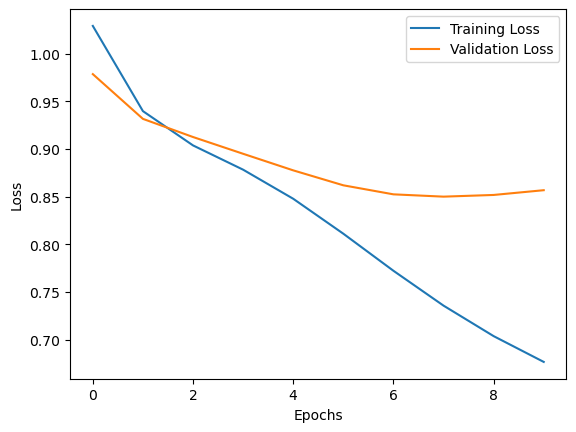

In [ ]:
# Plotting training and validation loss
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy (if available)
if 'accuracy' in history:
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Enregistrer l'historique dans un fichier CSV
import pandas as pd
history_df = pd.DataFrame(history)
history_df.to_csv('history.csv', index=False)


In [ ]:
model.save('movielens_model.h5')

### 6- Recommendation for Users


In [ ]:
# Get users not in the training set
users_not_in_train = set(test_data['userId']) - set(train_data['userId'])

# Convert the set to a list for random selection
users_not_in_train_list = list(users_not_in_train)

# Select 10 random users from those not in the training set
selected_users = random.sample(users_not_in_train_list, 10)
movielens_model= load_model('movielens_model.h5')


In [ ]:
unrated_movies = {}
for user_id in selected_users:
    user_movies = test_data[test_data['userId'] == user_id]['movieId'].values
    unrated_movies[user_id] = list(set(test_data['movieId']) - set(user_movies))



In [ ]:
recommended_movies = {}  # Dictionary to store recommended movies for each user

for user_id in unrated_movies:
    genres = test_data[test_data['userId'] == user_id]['genres'].values[0]

    user_ids = [user_id] * len(unrated_movies[user_id])
    predictions = movielens_model.predict([
        np.array(user_ids),
        np.array(unrated_movies[user_id]),
        np.array([genres] * len(unrated_movies[user_id]))
    ]) + mu

    recommended_movies[user_id] = []  # List to store recommended movie indices for the user
    count = 0  # Counter to track the number of recommended movies

    # Store user-book pairs and predictions, limit to 5 recommendations
    for movie_id, prediction in zip(unrated_movies[user_id], predictions):
        if count < 5:
            if prediction.shape == ():  # Check if prediction is a scalar
                recommended_movies[user_id].append((movie_id, prediction))  # Append directly if scalar
            else:
                recommended_movies[user_id].append((movie_id, prediction[0]))  # Append first element of prediction array
            count += 1

# Display recommended movie indices along with corresponding users
for user_id, recommendations in recommended_movies.items():
    print(f"User {user_id} recommended movies:")
    for movie_id, prediction in recommendations:
        print(f"Movie ID: {movie_id}, Prediction: {prediction}")


264/264 [==============================] - 1s 2ms/step
User 49373 recommended movies:
Movie ID: 0, Prediction: 3.4363434314727783
Movie ID: 1, Prediction: 3.1094532012939453
Movie ID: 2, Prediction: 2.9839162826538086
Movie ID: 3, Prediction: 2.2923712730407715
Movie ID: 4, Prediction: 2.965200185775757
User 29103 recommended movies:
Movie ID: 0, Prediction: 4.306923866271973
Movie ID: 1, Prediction: 3.9800336360931396
Movie ID: 2, Prediction: 3.854496479034424
Movie ID: 3, Prediction: 3.1629514694213867
Movie ID: 4, Prediction: 3.835780382156372
User 12122 recommended movies:
Movie ID: 0, Prediction: 3.418591022491455
Movie ID: 1, Prediction: 3.091700792312622
Movie ID: 2, Prediction: 2.9661636352539062
Movie ID: 3, Prediction: 2.274618625640869
Movie ID: 4, Prediction: 2.9474475383758545
User 64835 recommended movies:
Movie ID: 0, Prediction: 3.814732789993286
Movie ID: 1, Prediction: 3.4878427982330322
Movie ID: 2, Prediction: 3.3623056411743164
Movie ID: 3, Prediction: 2.6707606315

### 7-Recommendation Evaluation:

In [ ]:
# Let's assume 'merged_data' contains all the necessary information for predictions
# Select 10 random users
random_users = np.random.choice(merged_ml_data['userId'].unique(), size=10, replace=False)

# Generate predictions for these users on the movies they have rated
recommendations = []
for user_id in random_users:
    # Get movies already rated by the user
    movies_rated_by_user = np.random.choice(merged_ml_data[merged_ml_data['userId'] == user_id]['movieId'].unique(), size=2)

    # Prepare input data for the user only on the movies rated
    user_input = np.array([user_id for _ in range(len(movies_rated_by_user))])
    movie_input = np.array(movies_rated_by_user)
    genre_input = np.array([merged_ml_data[(merged_ml_data['userId'] == user_id) & (merged_ml_data['movieId'] == movie)]['genres'].iloc[0] for movie in movies_rated_by_user])

    # Get model predictions
    predictions = movielens_model.predict([user_input, movie_input, genre_input]) + mu

    # Combine movie IDs with their predicted ratings
    user_recommendations = list(zip(movie_input, predictions))

    # Sort recommendations by the predicted ratings
    user_recommendations.sort(key=lambda x: x[1], reverse=True)

    # Keep the top 5 recommended movies
    top_n_recommendations = user_recommendations[:5]

    # Retrieve the true ratings for the movies rated by the user
    true_ratings = [(movie, merged_ml_data[(merged_ml_data['userId'] == user_id) & (merged_ml_data['movieId'] == movie)]['rating'].iloc[0]) for movie in movies_rated_by_user]

    # Display recommendations and true ratings for this user
    recommendations.append({'userId': user_id, 'Top Recommendations': top_n_recommendations, 'True Ratings': true_ratings})

# Display recommendations for each user along with the true ratings
for user_rec in recommendations:
    print(f"User ID: {user_rec['userId']}")
    print("Recommendations & Ratings:")
    for i, ((movie_id, pred_rating), (movie_id_true, true_rating)) in enumerate(zip(user_rec['Top Recommendations'], user_rec['True Ratings']), start=1):
        print(f"  Recommendation {i}: Movie ID - {movie_id}, Predicted Rating - {pred_rating}, True Rating - {true_rating}")
    print()


1/1 [==============================] - 0s 37ms/step
User ID: 67667
Recommendations & Ratings:
  Recommendation 1: Movie ID - 308, Predicted Rating - [3.1734612], True Rating - 4.0
  Recommendation 2: Movie ID - 308, Predicted Rating - [3.1734612], True Rating - 4.0

User ID: 71159
Recommendations & Ratings:
  Recommendation 1: Movie ID - 4908, Predicted Rating - [3.6347747], True Rating - 5.0
  Recommendation 2: Movie ID - 4908, Predicted Rating - [3.6347747], True Rating - 5.0

User ID: 5856
Recommendations & Ratings:
  Recommendation 1: Movie ID - 147, Predicted Rating - [1.6684617], True Rating - 1.0
  Recommendation 2: Movie ID - 147, Predicted Rating - [1.6684617], True Rating - 1.0

User ID: 89329
Recommendations & Ratings:
  Recommendation 1: Movie ID - 2094, Predicted Rating - [3.134976], True Rating - 4.0
  Recommendation 2: Movie ID - 2094, Predicted Rating - [3.134976], True Rating - 4.0

User ID: 3923
Recommendations & Ratings:
  Recommendation 1: Movie ID - 13, Predicted R

**The recommendations for these 10 users are significantly better. As observed, the predicted ratings are much closer to the actual ratings in this case. Text-aware recommender systems demonstrate superior performance, leading to a more satisfying user experience.**

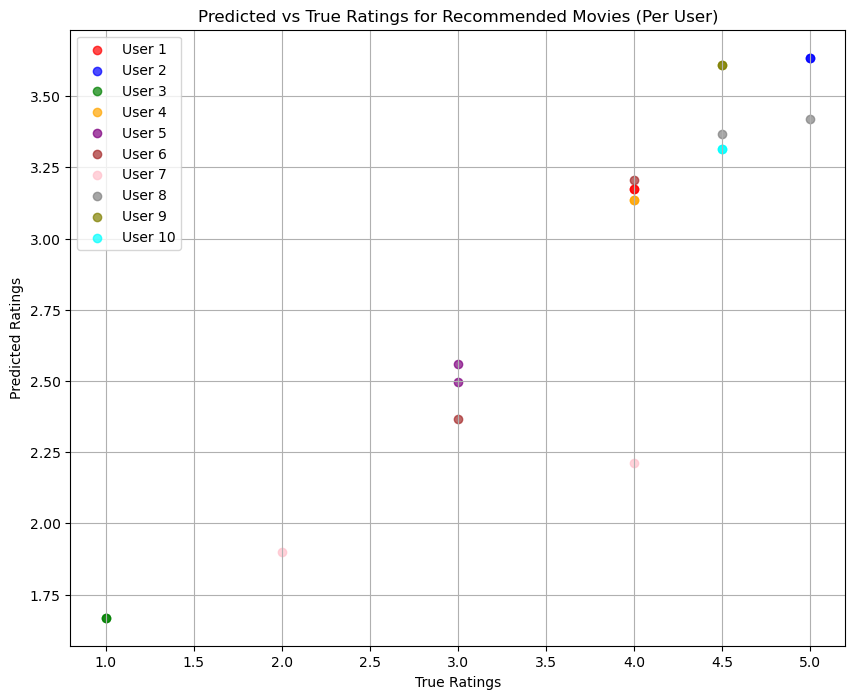

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Colors for different users
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

# Initialize lists to store predicted and true ratings for each user
all_predicted_ratings = []
all_true_ratings = []

# Extract predicted and true ratings from recommendations for each user
for idx, user_rec in enumerate(recommendations):
    predicted_ratings = []
    true_ratings = []
    for (_, pred_rating), (_, true_rating) in zip(user_rec['Top Recommendations'], user_rec['True Ratings']):
        predicted_ratings.append(pred_rating[0])  # Assuming pred_rating is a single-element array
        true_ratings.append(true_rating)
    all_predicted_ratings.append(predicted_ratings)
    all_true_ratings.append(true_ratings)

# Create scatter plots for each user
plt.figure(figsize=(10, 8))
for i in range(len(all_predicted_ratings)):
    plt.scatter(all_true_ratings[i], all_predicted_ratings[i], alpha=0.7, color=colors[i], label=f'User {i+1}')

plt.title('Predicted vs True Ratings for Recommended Movies (Per User)')
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Initialize lists to store true ratings and predicted ratings
true_ratings_all = []
predicted_ratings_all = []

# Loop through the recommendations for the 10 users
for user_rec in recommendations:
    true_ratings = [true_rating for _, true_rating in user_rec['True Ratings']]
    predicted_ratings = [pred_rating for _, pred_rating in user_rec['Top Recommendations']]

    true_ratings_all.extend(true_ratings)
    predicted_ratings_all.extend(predicted_ratings)

# Calculate RMSE
rmse = sqrt(mean_squared_error(true_ratings_all, predicted_ratings_all))
print(f"RMSE for the recommendations: {rmse}")


RMSE for the recommendations: 1.0847120958468968


**In the case of MovieLens Dataset The model's predictive performance exhibits variability across users. While it accurately predicts preferences for some users, it demonstrates inconsistencies and errors for others. Overall, the model's effectiveness varies, demonstrating satisfactory performance for certain users but requiring improvement for others. This highlights the need for further refinement in its predictive capabilities.**

# Report & brief summary of the experiment on context-aware recommendation systems:

**In this experiment, I investigated the effectiveness of a context-aware recommendation system (RS) using two different datasets: book recommendations and MovieLens. The objective was to improve the accuracy and relevance of recommendations, ultimately leading to a more personalized and satisfying user experience. As the results demonstrate, the context-aware RS yielded promising outcomes for movie recommendations. However, its performance for book recommendations was less satisfactory. This suggests that the context-aware approach may have limitations in certain domains.**